In [1]:
import os

DATASET = 'C:/Users/kaiqu/dog-or-cat/dataset/dogbreed/images/Images'

CLASSES = sorted([b for b in os.listdir(DATASET) if os.path.isdir(os.path.join(DATASET, b))])
print(f'Número de raças: {len(CLASSES)}')

Número de raças: 120


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

def criar_dataframe(base_dir, test_size):
    files = []

    # coleta as imagens e suas classes
    for breed in CLASSES:
        breed_dir = os.path.join(base_dir, breed)
        if not os.path.isdir(breed_dir):
            continue

        # obtém as imagens por raça e sua quantidade
        images = [f for f in os.listdir(breed_dir) if f.endswith(('.jpg', 'png', 'jpeg', 'webp'))]
        print(f'Número de imagens da raça {breed}: {len(images)}')

        # adiciona as imagens para o files
        for img in images:
            files.append({
                'filename': os.path.join(breed_dir, img),
                'class': breed
            })

    # criar o dataframe, cada linha representa uma imagem
    files_df = pd.DataFrame(files)
    print(f'Total de imagens no dataset: {len(files_df)}')

    # dividir o dataframe em treino e teste
    train_df, test_df = train_test_split(
        files_df,
        test_size=test_size,
        stratify=files_df['class'],
        random_state=42
        )

    print(f"Divisão virtual dos dados (sem mover arquivos):")
    print(f"- {len(train_df)} imagens ({(1-test_size)*100:.0f}%) para treino")
    print(f"- {len(test_df)} imagens ({test_size*100:.0f}%) para teste")

    # codificação one-hot-encoded para as classes
    train_df = pd.get_dummies(train_df, columns=['class'])
    test_df = pd.get_dummies(test_df, columns=['class'])

    return train_df, test_df

In [5]:
# criar dataframes de treino e teste
train_df, test_df = criar_dataframe(DATASET, 0.2)

print(f"Número de imagens para treino: {len(train_df)}")
print(f"Média de imagens para treino classe: {train_df.iloc[:, 1:].sum(axis=0).mean():.2f}")
print(f"Número de imagens para teste: {len(test_df)}")
print(f"Média de imagens para teste classe: {test_df.iloc[:, 1:].sum(axis=0).mean():.2f}")

Número de imagens da raça n02085620-Chihuahua: 152
Número de imagens da raça n02085782-Japanese_spaniel: 185
Número de imagens da raça n02085936-Maltese_dog: 252
Número de imagens da raça n02086079-Pekinese: 149
Número de imagens da raça n02086240-Shih-Tzu: 214
Número de imagens da raça n02086646-Blenheim_spaniel: 188
Número de imagens da raça n02086910-papillon: 196
Número de imagens da raça n02087046-toy_terrier: 172
Número de imagens da raça n02087394-Rhodesian_ridgeback: 172
Número de imagens da raça n02088094-Afghan_hound: 239
Número de imagens da raça n02088238-basset: 175
Número de imagens da raça n02088364-beagle: 195
Número de imagens da raça n02088466-bloodhound: 187
Número de imagens da raça n02088632-bluetick: 171
Número de imagens da raça n02089078-black-and-tan_coonhound: 159
Número de imagens da raça n02089867-Walker_hound: 153
Número de imagens da raça n02089973-English_foxhound: 157
Número de imagens da raça n02090379-redbone: 148
Número de imagens da raça n02090622-bo

Exemplos de Chihuahua:


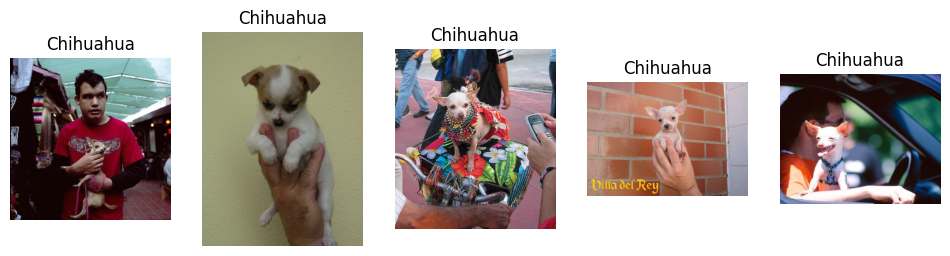

Exemplos de Japanese_spaniel:


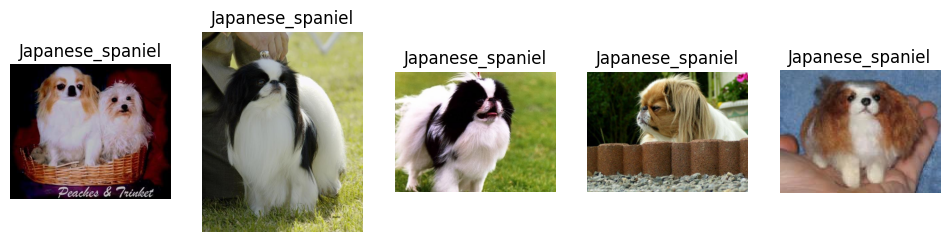

Exemplos de Maltese_dog:


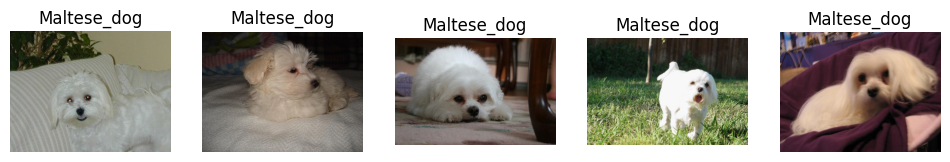

Exemplos de Pekinese:


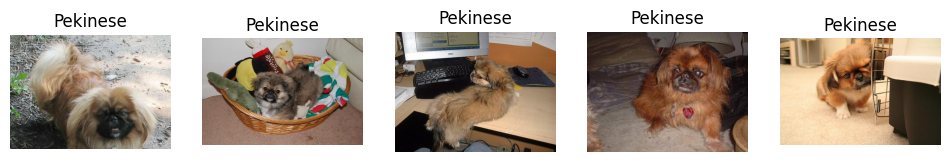

Exemplos de Shih-Tzu:


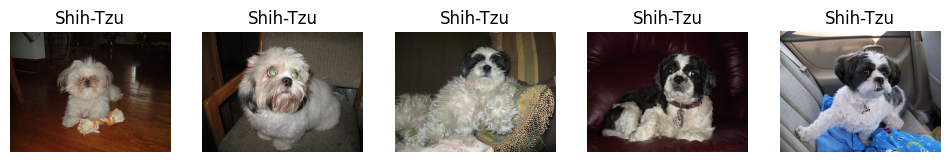

In [6]:
import matplotlib.pyplot as plt
import cv2

def grid_exemplo(dataframe, classe, num_exemplos):
    col_classe = f'class_{classe}'
    if col_classe not in dataframe.columns:
        print(f'Classe {classe} não encontrada no dataframe.')
        return

    # filtra o dataframe pela classe
    df_classe = dataframe[dataframe[col_classe] == 1]['filename'].tolist()[:num_exemplos]

    # plota os exemplos
    plt.figure(figsize=(12, 4))
    for i, img_dir in enumerate(df_classe):
        img = cv2.imread(img_dir)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_exemplos, i + 1)
        plt.imshow(img)
        nome_limpo = classe.split('-', 1)[1]
        plt.title(f'{nome_limpo}')
        plt.axis('off')
    plt.show()

for classe in CLASSES[:5]:
    nome_limpo = classe.split('-', 1)[1]
    print(f"Exemplos de {nome_limpo}:")
    grid_exemplo(train_df, classe, 5)

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B3

IMG_SIZE = 300

def load_preprocess_image(file):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

In [8]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class DataFrameGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, x_col, y_cols, batch_size,
                 img_size = (IMG_SIZE, IMG_SIZE), shuffle=True, augment = True):
        self.df = dataframe.copy()
        self.x_col = x_col
        self.y_cols = y_cols
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.n = len(self.df)
        self.indices = np.arange(self.n)
        self.datagen = None

        # augmentação de dados
        if self.augment:
            self.datagen = ImageDataGenerator(
                rotation_range=30,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                brightness_range=[0.8, 1.2],
                fill_mode='nearest'
            )

        self.on_epoch_end()

        # obtemos os nomes das classes do one hot encoding
        self.class_indices = {}
        for i, col in enumerate([c for c in self.df.columns if c.startswith('class_')]):
            self.class_indices[col.replace('class_', '')] = i # troca o class_ pelo nome da classe (i)
        self.classes = np.argmax(self.df[self.y_cols].values, axis = 1)

    def __len__(self):
        return int(np.ceil(self.n / self.batch_size))

    def __getitem__(self, index):
        batch_index = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_x = np.array([load_preprocess_image(file) for file in self.df.iloc[batch_index][self.x_col]])
        batch_y = self.df.iloc[batch_index][self.y_cols].values

        if self.augment:
            batch_x = np.array([self.datagen.random_transform(img) for img in batch_x])

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def reset(self):
        self.on_epoch_end()

In [9]:
y_cols = [col for col in train_df.columns if col.startswith('class_')]

train_df_final, val_df_final = train_test_split(
    train_df,
    test_size = 0.2,
    stratify = np.argmax(train_df[y_cols].values, axis = 1),
    random_state = 42
)

In [10]:
train_generator = DataFrameGenerator(
    train_df_final,
    'filename',
    y_cols,
    batch_size = 32,
    img_size = (IMG_SIZE, IMG_SIZE),
    shuffle = True,
    augment = True
)

val_generator = DataFrameGenerator(
    val_df_final,
    'filename',
    y_cols,
    batch_size = 32,
    img_size = (IMG_SIZE, IMG_SIZE),
    shuffle = False,
    augment = False
)

test_generator = DataFrameGenerator(
    test_df,
    'filename',
    y_cols,
    batch_size = 32,
    img_size = (IMG_SIZE, IMG_SIZE),
    shuffle = False,
    augment = False
)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-6),
    ModelCheckpoint('base_original_model.h5', save_best_only=True, monitor='val_loss', mode='min'),
]

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

def criar_modelo():
    base_model = EfficientNetV2B3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    base_model.trainable = False  # Congela a base

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(len(CLASSES), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
        )

    return model, base_model

In [13]:
model, base_model = criar_modelo()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 300, 300, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 300, 300, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 150, 150, 40  1080        ['normalization[0][0]']      

In [14]:
print(f"Número de classes no modelo: {len(y_cols)}")
print(f"Número de pastas de classes: {len(CLASSES)}")

# Treinamento inicial com o modelo base congelado
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks
)

Número de classes no modelo: 120
Número de pastas de classes: 120


Epoch 1/10
412/412 [==============================] - 275s 634ms/step - loss: 1.1521 - accuracy: 0.7100 - val_loss: 0.2660 - val_accuracy: 0.9162 - lr: 0.0010
Epoch 2/10
412/412 [==============================] - 259s 629ms/step - loss: 0.5636 - accuracy: 0.8342 - val_loss: 0.2179 - val_accuracy: 0.9323 - lr: 0.0010
Epoch 3/10
412/412 [==============================] - 254s 616ms/step - loss: 0.5152 - accuracy: 0.8466 - val_loss: 0.2297 - val_accuracy: 0.9277 - lr: 0.0010
Epoch 4/10
412/412 [==============================] - 250s 606ms/step - loss: 0.4836 - accuracy: 0.8573 - val_loss: 0.2487 - val_accuracy: 0.9259 - lr: 0.0010
Epoch 5/10
412/412 [==============================] - 262s 637ms/step - loss: 0.4535 - accuracy: 0.8598 - val_loss: 0.2248 - val_accuracy: 0.9353 - lr: 0.0010
Epoch 6/10
412/412 [==============================] - 272s 659ms/step - loss: 0.3413 - accuracy: 0.8904 - val_loss: 0.2002 - val_accuracy: 0.9420 - lr: 1.0000e-04
Epoch 7/10
412/412 [======================

In [15]:
model.save('base_original_model.h5')
print("Modelo base salvo como 'base_original_model.h5'")

Modelo base salvo como 'base_original_model.h5'


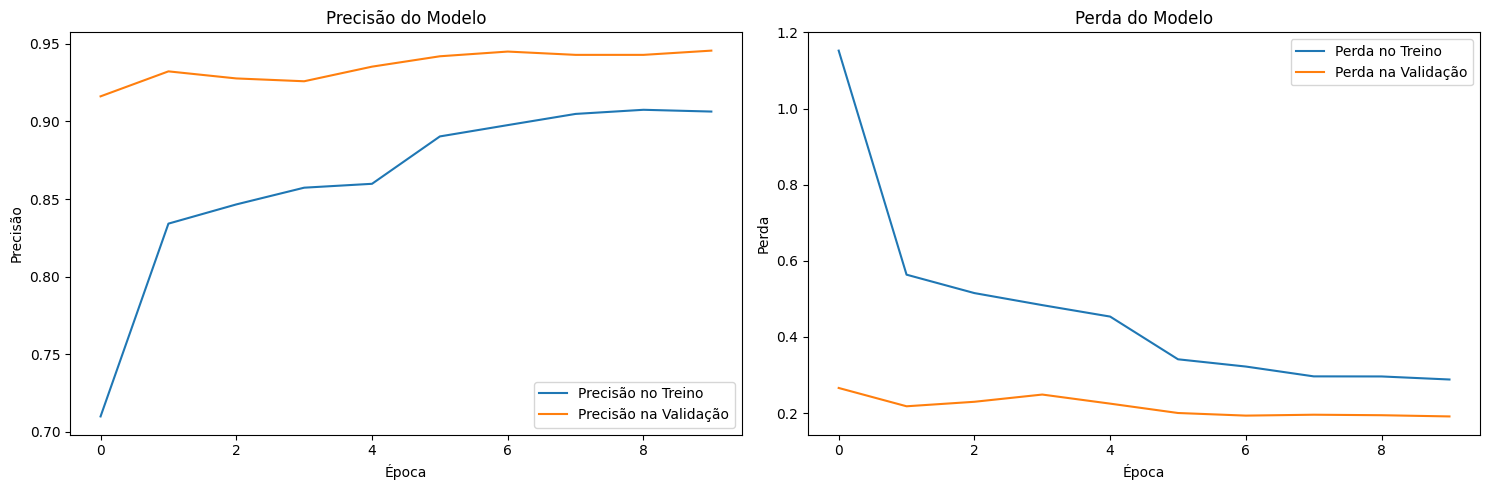

In [16]:
def plotar_historico(historico):
    """Plota o histórico de treinamento do modelo."""
    acc = historico.history['accuracy']
    val_acc = historico.history['val_accuracy']
    loss = historico.history['loss']
    val_loss = historico.history['val_loss']

    plt.figure(figsize=(15, 5))

    # Gráfico de precisão
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Precisão no Treino')
    plt.plot(val_acc, label='Precisão na Validação')
    plt.title('Precisão do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Precisão')
    plt.legend()

    # Gráfico de perda
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Perda no Treino')
    plt.plot(val_loss, label='Perda na Validação')
    plt.title('Perda do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotar o histórico de treinamento
plotar_historico(history)

In [17]:
# Avaliar o modelo nos dados de teste
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Precisão no teste: {test_accuracy:.4f}")

129/129 [==============================] - 16s 124ms/step - loss: 0.1705 - accuracy: 0.9448
Precisão no teste: 0.9448


129/129 [==============================] - 17s 115ms/step


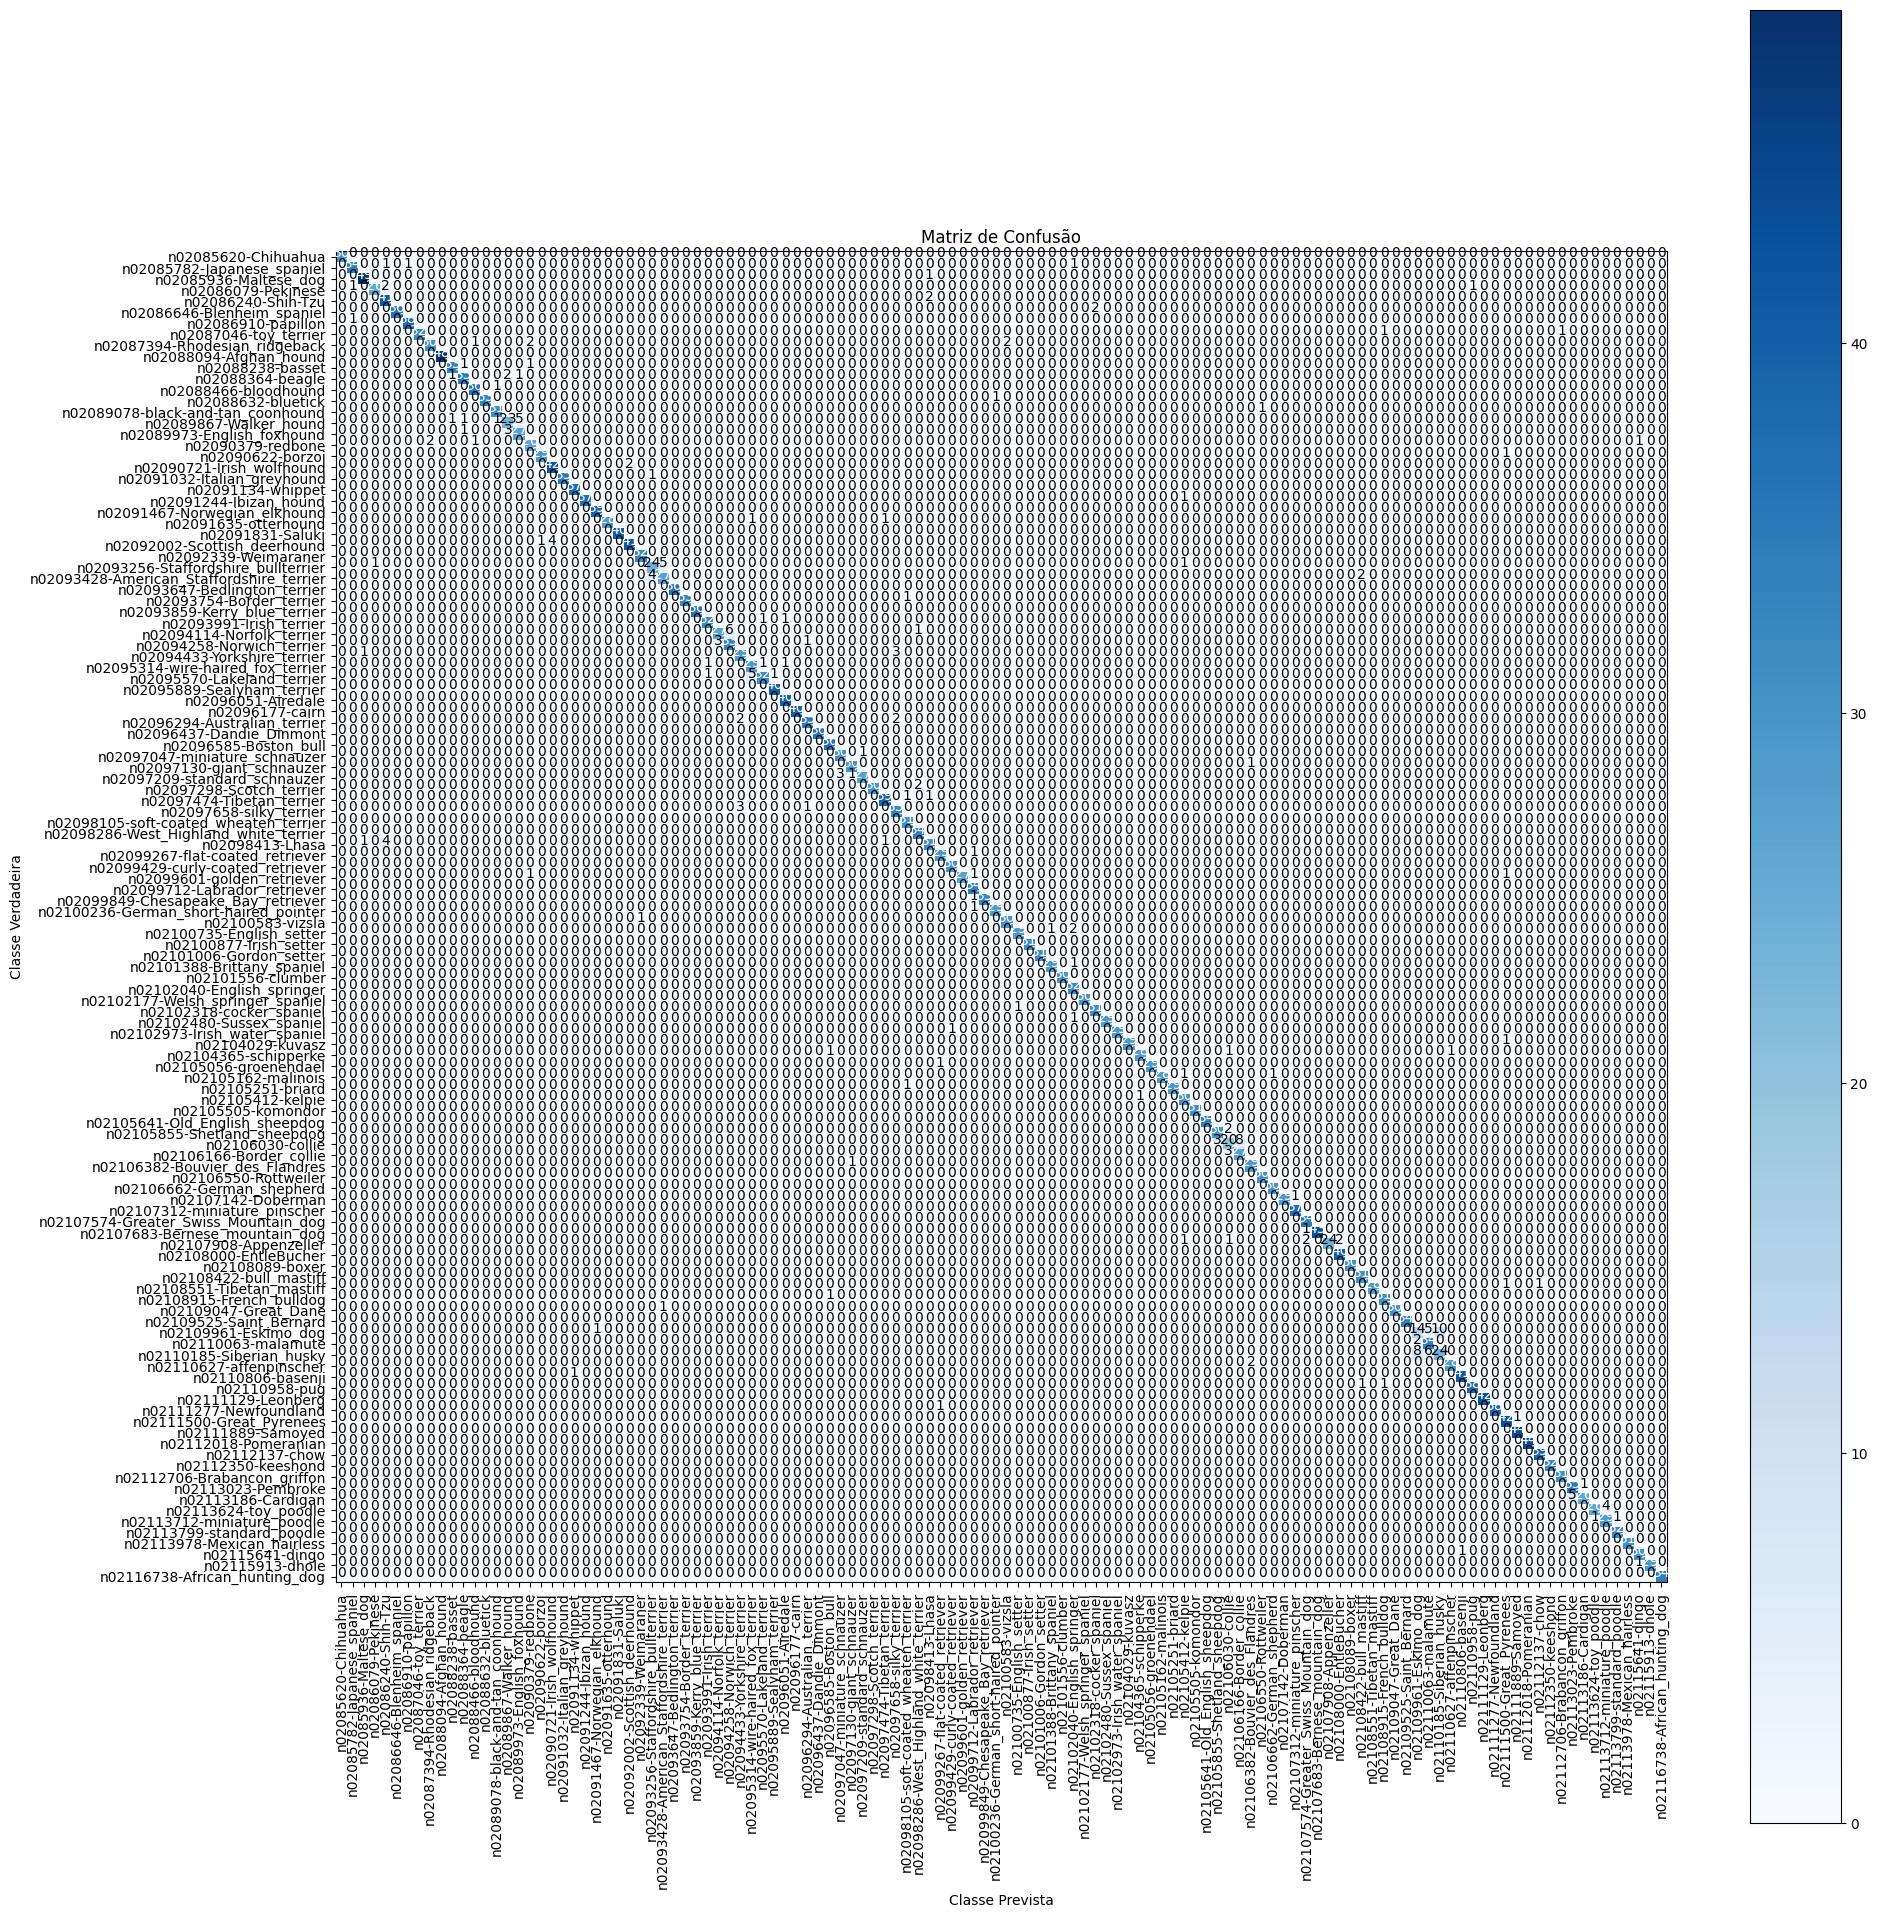

Relatório de Classificação:
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       1.00      1.00      1.00        30
              n02085782-Japanese_spaniel       0.94      0.92      0.93        37
                   n02085936-Maltese_dog       0.96      0.98      0.97        50
                      n02086079-Pekinese       0.96      0.87      0.91        30
                      n02086240-Shih-Tzu       0.85      0.95      0.90        43
              n02086646-Blenheim_spaniel       1.00      0.95      0.97        38
                      n02086910-papillon       0.97      0.97      0.97        39
                   n02087046-toy_terrier       1.00      0.94      0.97        34
           n02087394-Rhodesian_ridgeback       0.94      0.86      0.90        35
                  n02088094-Afghan_hound       1.00      1.00      1.00        48
                        n02088238-basset       0.94      0.94      0.

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Fazer previsões no conjunto de teste
previsoes = model.predict(test_generator)
previsoes_classes = np.argmax(previsoes, axis=1)

# Obter os rótulos verdadeiros
rotulos_verdadeiros = test_generator.classes

# Matriz de confusão
matriz_confusao = confusion_matrix(rotulos_verdadeiros, previsoes_classes)

# Criar figura da matriz de confusão
plt.figure(figsize=(20, 20))
plt.imshow(matriz_confusao, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
tick_marks = np.arange(len(CLASSES))
plt.xticks(tick_marks, CLASSES, rotation=90)
plt.yticks(tick_marks, CLASSES)

for i in range(len(CLASSES)):
    for j in range(len(CLASSES)):
        plt.text(j, i, format(matriz_confusao[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if matriz_confusao[i, j] > matriz_confusao.max() / 2 else "black")

plt.tight_layout()
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')

# Salvar a matriz de confusão como imagem
plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=300)
plt.show()

# Relatório de classificação
relatorio = classification_report(rotulos_verdadeiros, previsoes_classes, target_names=CLASSES, zero_division=0)
print("Relatório de Classificação:")
print(relatorio)

1/1 [==============================] - 2s 2s/step


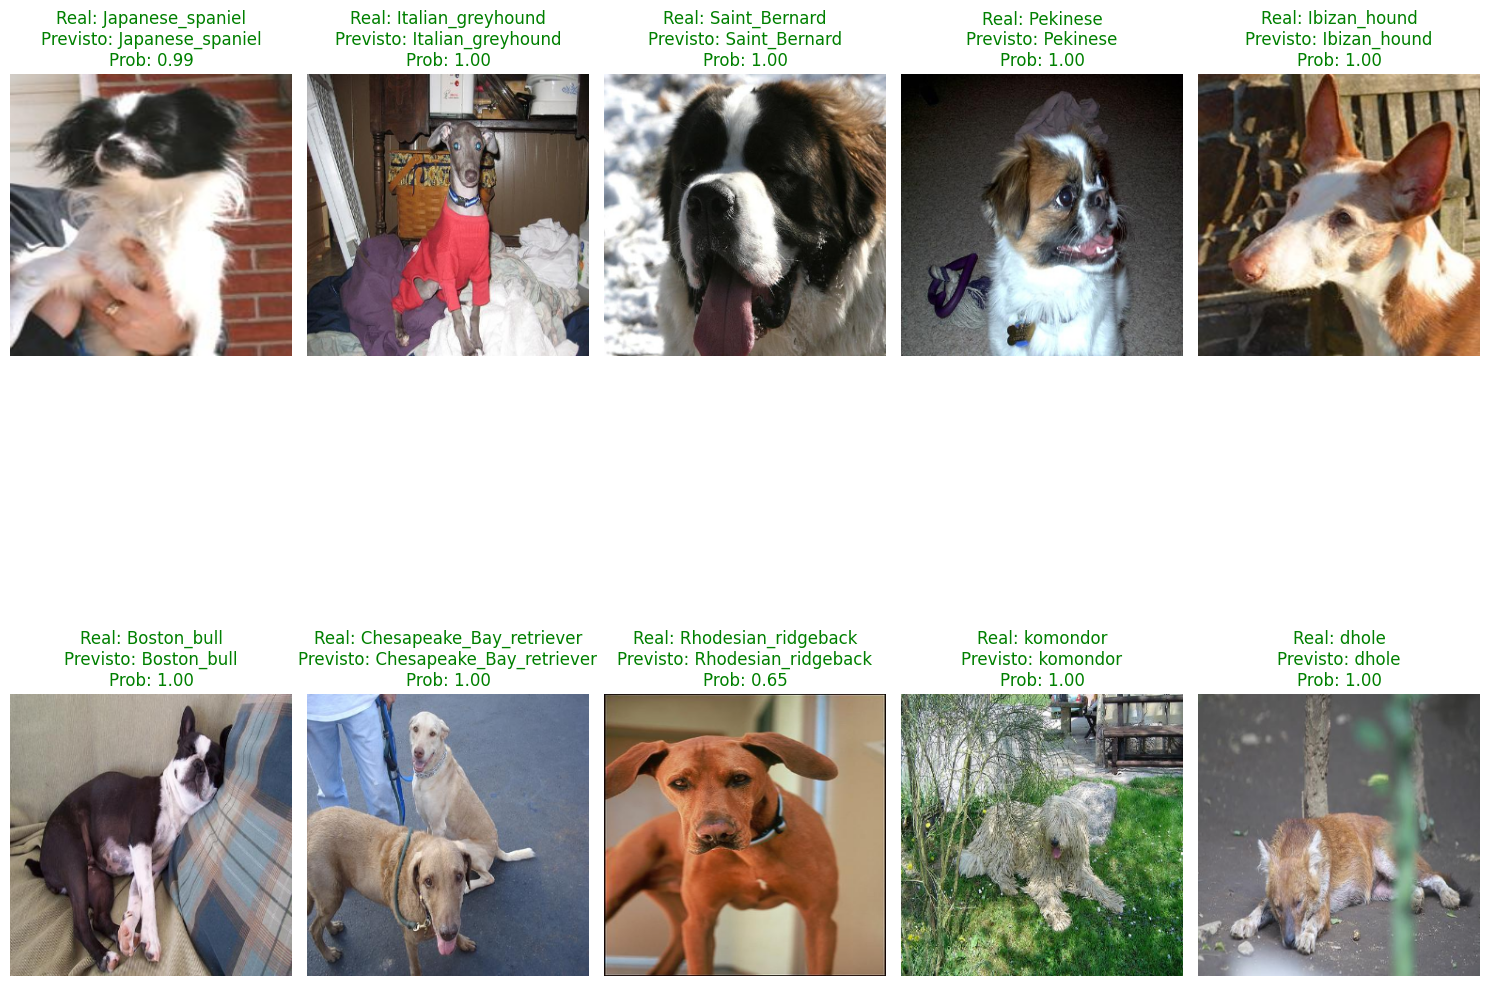

In [19]:
def visualizar_previsoes(modelo, gerador, num_exemplos=10):
    """Visualiza algumas previsões do modelo."""
    # Obter um batch de dados
    imagens, rotulos = next(iter(gerador))

    # Fazer previsões
    previsoes = modelo.predict(imagens)
    previsoes_classes = np.argmax(previsoes, axis=1)

    # Mostrar as imagens com as previsões
    plt.figure(figsize=(15, num_exemplos * 2))
    for i in range(min(num_exemplos, len(imagens))):
        plt.subplot(num_exemplos//5 + 1, 5, i+1)
        plt.imshow(imagens[i])
        # Extrair o rótulo real com np.argmax (assumindo codificação one-hot)
        rotulo_real = np.argmax(rotulos[i])
        cor = "green" if previsoes_classes[i] == rotulo_real else "red"
        rotulo_correto = CLASSES[rotulo_real].split('-', 1)[1]
        rotulo_previsto = CLASSES[previsoes_classes[i]].split('-', 1)[1]
        probabilidade = previsoes[i][previsoes_classes[i]]

        plt.title(f"Real: {rotulo_correto}\nPrevisto: {rotulo_previsto}\nProb: {probabilidade:.2f}", color=cor)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# Resetar o gerador de teste
test_generator.reset()

# Visualizar algumas previsões
visualizar_previsoes(model, test_generator)

In [ ]:
from tensorflow.keras.models import load_model

def load_preprocess_image(file):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

def test_image(file):
    model = load_model('C:/Users/kaiqu/dog-or-cat/modelos/base_original_model.h5')

    img = load_preprocess_image(file)

    # Exibe a imagem
    plt.imshow(img)
    plt.title(f"Imagem Externa ({file})")
    plt.axis("off")
    plt.show()

    img_expanded = np.expand_dims(img, axis=0)

    # Realiza a predição
    previsao = model.predict(img_expanded)
    print("Predição (vetor de probabilidades):")
    # print(previsao)

    # # Ordena os índices de acordo com as probabilidades (do menor para o maior)
    indices_ordenados = np.argsort(previsao[0])
    # # Seleciona os 5 índices com maiores probabilidades e inverte a ordem (do maior para o menor)
    top5_indices = indices_ordenados[-5:][::-1]
    print("Top 5 índices:", top5_indices)

    # print("Top 5 raças mais prováveis:")
    for i in top5_indices:
        print(f"Raça: {CLASSES[i]} - Probabilidade: {(previsao[0][i]) * 100:.2f}%")

In [33]:
test_image('Untitled.jpg')

OSError: No file or directory found at /modelos/base_original_model.h5

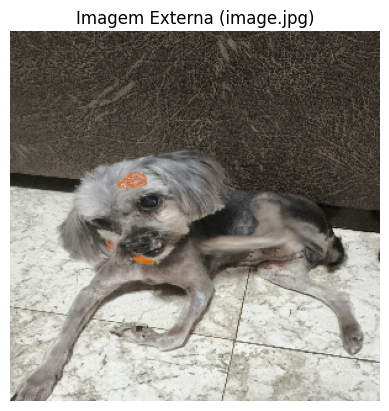

1/1 [==============================] - 2s 2s/step
Predição (vetor de probabilidades):
Top 5 índices: [  4 113  36   0  53]
Raça: n02086240-Shih-Tzu - Probabilidade: 56.96%
Raça: n02113624-toy_poodle - Probabilidade: 26.41%
Raça: n02094433-Yorkshire_terrier - Probabilidade: 7.84%
Raça: n02085620-Chihuahua - Probabilidade: 5.01%
Raça: n02098413-Lhasa - Probabilidade: 0.96%


In [22]:
test_image('image.jpg')

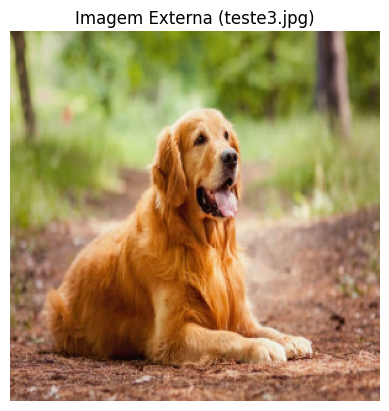

1/1 [==============================] - 2s 2s/step
Predição (vetor de probabilidades):
Top 5 índices: [56 57 68 62  8]
Raça: n02099601-golden_retriever - Probabilidade: 100.00%
Raça: n02099712-Labrador_retriever - Probabilidade: 0.00%
Raça: n02102318-cocker_spaniel - Probabilidade: 0.00%
Raça: n02100877-Irish_setter - Probabilidade: 0.00%
Raça: n02087394-Rhodesian_ridgeback - Probabilidade: 0.00%


In [23]:
test_image('teste3.jpg')

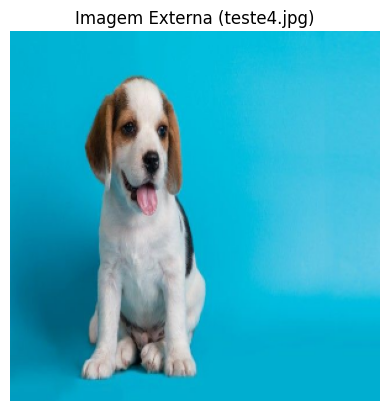

1/1 [==============================] - 2s 2s/step
Predição (vetor de probabilidades):
Top 5 índices: [11 64 16 15 96]
Raça: n02088364-beagle - Probabilidade: 98.02%
Raça: n02101388-Brittany_spaniel - Probabilidade: 0.88%
Raça: n02089973-English_foxhound - Probabilidade: 0.32%
Raça: n02089867-Walker_hound - Probabilidade: 0.31%
Raça: n02109525-Saint_Bernard - Probabilidade: 0.19%


In [24]:
test_image('teste4.jpg')

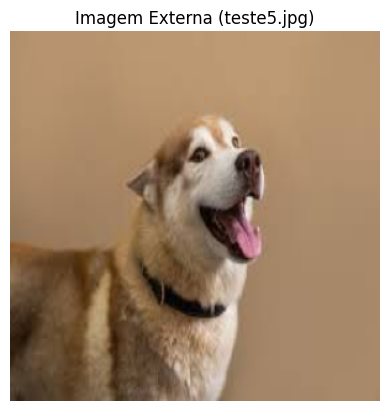

1/1 [==============================] - 2s 2s/step
Predição (vetor de probabilidades):
Top 5 índices: [97 99 98 64 23]
Raça: n02109961-Eskimo_dog - Probabilidade: 58.78%
Raça: n02110185-Siberian_husky - Probabilidade: 36.35%
Raça: n02110063-malamute - Probabilidade: 4.15%
Raça: n02101388-Brittany_spaniel - Probabilidade: 0.08%
Raça: n02091467-Norwegian_elkhound - Probabilidade: 0.07%


In [25]:
test_image('teste5.jpg')

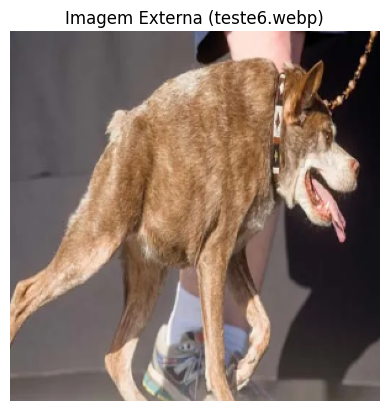

1/1 [==============================] - 2s 2s/step
Predição (vetor de probabilidades):
Top 5 índices: [ 22  97  99 117  21]
Raça: n02091244-Ibizan_hound - Probabilidade: 43.34%
Raça: n02109961-Eskimo_dog - Probabilidade: 25.00%
Raça: n02110185-Siberian_husky - Probabilidade: 13.55%
Raça: n02115641-dingo - Probabilidade: 7.04%
Raça: n02091134-whippet - Probabilidade: 1.82%


In [26]:
test_image('teste6.webp')

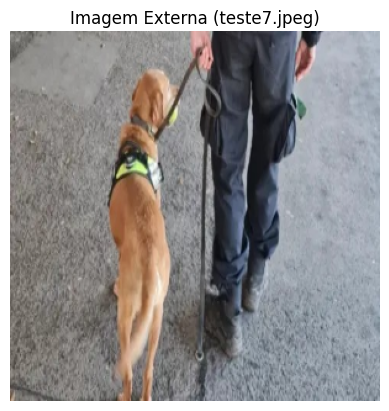

1/1 [==============================] - 2s 2s/step
Predição (vetor de probabilidades):
Top 5 índices: [17 56 12 58 57]
Raça: n02090379-redbone - Probabilidade: 69.04%
Raça: n02099601-golden_retriever - Probabilidade: 12.02%
Raça: n02088466-bloodhound - Probabilidade: 4.56%
Raça: n02099849-Chesapeake_Bay_retriever - Probabilidade: 3.37%
Raça: n02099712-Labrador_retriever - Probabilidade: 3.21%


In [28]:
test_image('teste7.jpeg')

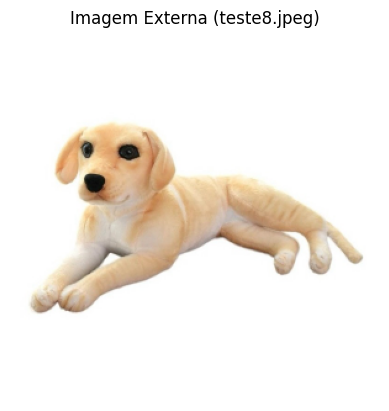

1/1 [==============================] - 2s 2s/step
Predição (vetor de probabilidades):
Top 5 índices: [57 56 54 60 58]
Raça: n02099712-Labrador_retriever - Probabilidade: 98.60%
Raça: n02099601-golden_retriever - Probabilidade: 1.27%
Raça: n02099267-flat-coated_retriever - Probabilidade: 0.02%
Raça: n02100583-vizsla - Probabilidade: 0.01%
Raça: n02099849-Chesapeake_Bay_retriever - Probabilidade: 0.01%


In [29]:
test_image('teste8.jpeg')